Importar librerías necesarias


In [1]:
# 1. Importar librerías necesarias
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
import numpy as np
import random
from tqdm import tqdm

# Fijar semilla para reproducibilidad
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Descargar y explorar el dataset CIFAR-100 de Hugging Face

In [2]:
# 2. Descargar y explorar el dataset CIFAR-100 de Hugging Face
dataset = load_dataset("uoft-cs/cifar100")
print(dataset)  # Mostrar las llaves y tamaños de los splits

Using the latest cached version of the dataset since uoft-cs/cifar100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'cifar100' at C:\Users\david\.cache\huggingface\datasets\uoft-cs___cifar100\cifar100\0.0.0\aadb3af77e9048adbea6b47c21a81e47dd092ae5 (last modified on Sun Jun  8 14:39:19 2025).
Found the latest cached dataset configuration 'cifar100' at C:\Users\david\.cache\huggingface\datasets\uoft-cs___cifar100\cifar100\0.0.0\aadb3af77e9048adbea6b47c21a81e47dd092ae5 (last modified on Sun Jun  8 14:39:19 2025).
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py:126: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  return _bootstrap._gcd_import(name[level:], package, level)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py:126: UserWarning:

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})


 Visualizar algunas imágenes de ejemplo

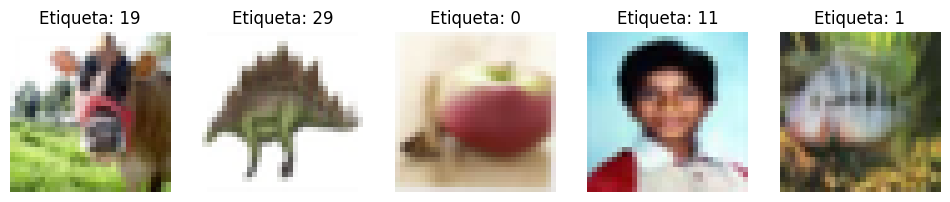

In [3]:
# 3. Visualizar algunas imágenes de ejemplo
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img = dataset["train"][i]["img"]
    label = dataset["train"][i]["fine_label"]
    axs[i].imshow(img)
    axs[i].set_title(f"Etiqueta: {label}")
    axs[i].axis("off")
plt.show()

Preprocesar los datos y crear Dataset personalizado

In [4]:
# 4. Preprocesar los datos y crear Dataset personalizado
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CIFAR100Dataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]["img"]
        label = self.dataset[idx]["fine_label"]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = CIFAR100Dataset(dataset["train"], transform=train_transform)
test_dataset = CIFAR100Dataset(dataset["test"], transform=test_transform)
val_dataset = CIFAR100Dataset(dataset["test"], transform=test_transform)  # val_dataset con test_transform

Dividir train en train y validación (80/20)

In [5]:
# 5. Dividir train en train y validación (80/20) y aplicar test_transform a validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
indices = list(range(len(train_dataset)))
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Subset para train y val
from torch.utils.data import Subset
train_dataset_split = Subset(train_dataset, train_indices)
val_dataset = CIFAR100Dataset(dataset["train"], transform=test_transform)
val_dataset_split = Subset(val_dataset, val_indices)

print(f"Tamaño train: {len(train_dataset_split)}, validación: {len(val_dataset_split)}, test: {len(test_dataset)}")

Tamaño train: 40000, validación: 10000, test: 10000


Definir el modelo de red neuronal

In [6]:
# 6. Definir un modelo de red convolucional mejorada para CIFAR-100
class RedCNNMejorada(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 4x4
            nn.Dropout(0.25)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo = RedCNNMejorada().to(device)
print(modelo)

RedCNNMejorada(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25,

Preparar DataLoaders

In [7]:
# 7. Preparar DataLoaders
BATCH_SIZE = 42
train_loader = DataLoader(train_dataset_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_split, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

 Definir funciones de entrenamiento y validación

In [8]:
# 8. Definir funciones de entrenamiento y validación
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def val_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

 Entrenar y validar el modelo

In [17]:
# 9. Entrenar y validar el modelo, guardando métricas, barra de progreso, early stopping y guardado del mejor modelo
EPOCHS = 40
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_path = 'mejor_modelo.pth'

# Scheduler de learning rate (sin verbose)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

for epoch in range(EPOCHS):
    print(f"\nÉpoca {epoch+1}/{EPOCHS}")
    # Barra de progreso para entrenamiento
    train_iter = tqdm(train_loader, desc='Entrenamiento', leave=False)
    modelo.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = modelo(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validación
    val_loss, val_acc = val_loop(val_loader, modelo, loss_fn)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"  Entrenamiento -> Pérdida: {train_loss:.4f}, Exactitud: {train_acc*100:.2f}%")
    print(f"  Validación    -> Pérdida: {val_loss:.4f}, Exactitud: {val_acc*100:.2f}%")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping y guardado del mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(modelo.state_dict(), best_model_path)
        print('  Mejor modelo guardado.')
    else:
        patience_counter += 1
        print(f'  Sin mejora en validación. Paciencia: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('  Early stopping: entrenamiento detenido.')
            break


Época 1/40


  Entrenamiento -> Pérdida: 2.7039, Exactitud: 30.36%
  Validación    -> Pérdida: 2.1670, Exactitud: 41.88%
  Mejor modelo guardado.

Época 2/40


  Entrenamiento -> Pérdida: 2.5112, Exactitud: 34.65%
  Validación    -> Pérdida: 2.0529, Exactitud: 45.08%
  Mejor modelo guardado.

Época 3/40


  Entrenamiento -> Pérdida: 2.3914, Exactitud: 37.29%
  Validación    -> Pérdida: 1.9459, Exactitud: 47.36%
  Mejor modelo guardado.

Época 4/40


  Entrenamiento -> Pérdida: 2.3161, Exactitud: 39.00%
  Validación    -> Pérdida: 1.9515, Exactitud: 47.54%
  Sin mejora en validación. Paciencia: 1/5

Época 5/40


  Entrenamiento -> Pérdida: 2.2640, Exactitud: 39.94%
  Validación    -> Pérdida: 1.8634, Exactitud: 48.92%
  Mejor modelo guardado.

Época 6/40


  Entrenamiento -> Pérdida: 2.2128, Exactitud: 41.27%
  Validación    -> Pérdida: 1.8173, Exactitud: 50.73%
  Mejor modelo guardado.

Época 7/40


  Entrenamiento -> Pérdida: 2.1668, Exactitud: 42.35%
  Validación    -> Pérdida: 1.7408, Exactitud: 51.98%
  Mejor modelo guardado.

Época 8/40


  Entrenamiento -> Pérdida: 2.1370, Exactitud: 42.82%
  Validación    -> Pérdida: 1.7309, Exactitud: 52.35%
  Mejor modelo guardado.

Época 9/40


  Entrenamiento -> Pérdida: 2.1084, Exactitud: 43.76%
  Validación    -> Pérdida: 1.7092, Exactitud: 53.34%
  Mejor modelo guardado.

Época 10/40


  Entrenamiento -> Pérdida: 2.0756, Exactitud: 44.34%
  Validación    -> Pérdida: 1.7156, Exactitud: 53.63%
  Sin mejora en validación. Paciencia: 1/5

Época 11/40


  Entrenamiento -> Pérdida: 2.0512, Exactitud: 44.66%
  Validación    -> Pérdida: 1.6973, Exactitud: 53.63%
  Mejor modelo guardado.

Época 12/40


  Entrenamiento -> Pérdida: 2.0258, Exactitud: 45.23%
  Validación    -> Pérdida: 1.6522, Exactitud: 54.68%
  Mejor modelo guardado.

Época 13/40


  Entrenamiento -> Pérdida: 2.0150, Exactitud: 45.88%
  Validación    -> Pérdida: 1.6425, Exactitud: 54.69%
  Mejor modelo guardado.

Época 14/40


  Entrenamiento -> Pérdida: 1.9954, Exactitud: 45.85%
  Validación    -> Pérdida: 1.6334, Exactitud: 54.91%
  Mejor modelo guardado.

Época 15/40


  Entrenamiento -> Pérdida: 1.9596, Exactitud: 46.84%
  Validación    -> Pérdida: 1.6625, Exactitud: 54.56%
  Sin mejora en validación. Paciencia: 1/5

Época 16/40


  Entrenamiento -> Pérdida: 1.9630, Exactitud: 47.30%
  Validación    -> Pérdida: 1.5999, Exactitud: 56.09%
  Mejor modelo guardado.

Época 17/40


  Entrenamiento -> Pérdida: 1.9424, Exactitud: 47.53%
  Validación    -> Pérdida: 1.6349, Exactitud: 55.30%
  Sin mejora en validación. Paciencia: 1/5

Época 18/40


  Entrenamiento -> Pérdida: 1.9149, Exactitud: 48.21%
  Validación    -> Pérdida: 1.6022, Exactitud: 55.99%
  Sin mejora en validación. Paciencia: 2/5

Época 19/40


  Entrenamiento -> Pérdida: 1.9111, Exactitud: 48.13%
  Validación    -> Pérdida: 1.5516, Exactitud: 56.62%
  Mejor modelo guardado.

Época 20/40


  Entrenamiento -> Pérdida: 1.8998, Exactitud: 48.61%
  Validación    -> Pérdida: 1.5822, Exactitud: 56.21%
  Sin mejora en validación. Paciencia: 1/5

Época 21/40


  Entrenamiento -> Pérdida: 1.8792, Exactitud: 48.95%
  Validación    -> Pérdida: 1.5658, Exactitud: 56.81%
  Sin mejora en validación. Paciencia: 2/5

Época 22/40


  Entrenamiento -> Pérdida: 1.8662, Exactitud: 49.30%
  Validación    -> Pérdida: 1.5442, Exactitud: 57.16%
  Mejor modelo guardado.

Época 23/40


  Entrenamiento -> Pérdida: 1.8551, Exactitud: 49.44%
  Validación    -> Pérdida: 1.5313, Exactitud: 57.59%
  Mejor modelo guardado.

Época 24/40


  Entrenamiento -> Pérdida: 1.8554, Exactitud: 49.40%
  Validación    -> Pérdida: 1.5397, Exactitud: 58.03%
  Sin mejora en validación. Paciencia: 1/5

Época 25/40


  Entrenamiento -> Pérdida: 1.8471, Exactitud: 49.85%
  Validación    -> Pérdida: 1.6009, Exactitud: 55.76%
  Sin mejora en validación. Paciencia: 2/5

Época 26/40


  Entrenamiento -> Pérdida: 1.8368, Exactitud: 50.07%
  Validación    -> Pérdida: 1.5167, Exactitud: 58.18%
  Mejor modelo guardado.

Época 27/40


  Entrenamiento -> Pérdida: 1.8320, Exactitud: 50.12%
  Validación    -> Pérdida: 1.5422, Exactitud: 57.53%
  Sin mejora en validación. Paciencia: 1/5

Época 28/40


  Entrenamiento -> Pérdida: 1.8269, Exactitud: 50.63%
  Validación    -> Pérdida: 1.5434, Exactitud: 57.62%
  Sin mejora en validación. Paciencia: 2/5

Época 29/40


  Entrenamiento -> Pérdida: 1.8040, Exactitud: 50.98%
  Validación    -> Pérdida: 1.5090, Exactitud: 58.43%
  Mejor modelo guardado.

Época 30/40


  Entrenamiento -> Pérdida: 1.8086, Exactitud: 50.52%
  Validación    -> Pérdida: 1.5374, Exactitud: 57.89%
  Sin mejora en validación. Paciencia: 1/5

Época 31/40


  Entrenamiento -> Pérdida: 1.7940, Exactitud: 51.01%
  Validación    -> Pérdida: 1.5239, Exactitud: 57.93%
  Sin mejora en validación. Paciencia: 2/5

Época 32/40


  Entrenamiento -> Pérdida: 1.7838, Exactitud: 51.31%
  Validación    -> Pérdida: 1.5053, Exactitud: 57.89%
  Mejor modelo guardado.

Época 33/40


  Entrenamiento -> Pérdida: 1.7792, Exactitud: 51.20%
  Validación    -> Pérdida: 1.4955, Exactitud: 58.33%
  Mejor modelo guardado.

Época 34/40


  Entrenamiento -> Pérdida: 1.7803, Exactitud: 51.33%
  Validación    -> Pérdida: 1.4932, Exactitud: 58.79%
  Mejor modelo guardado.

Época 35/40


  Entrenamiento -> Pérdida: 1.7761, Exactitud: 51.88%
  Validación    -> Pérdida: 1.4926, Exactitud: 58.61%
  Mejor modelo guardado.

Época 36/40


  Entrenamiento -> Pérdida: 1.7737, Exactitud: 51.72%
  Validación    -> Pérdida: 1.4686, Exactitud: 59.00%
  Mejor modelo guardado.

Época 37/40


  Entrenamiento -> Pérdida: 1.7754, Exactitud: 51.54%
  Validación    -> Pérdida: 1.5276, Exactitud: 58.14%
  Sin mejora en validación. Paciencia: 1/5

Época 38/40


  Entrenamiento -> Pérdida: 1.7583, Exactitud: 51.71%
  Validación    -> Pérdida: 1.4586, Exactitud: 59.39%
  Mejor modelo guardado.

Época 39/40


  Entrenamiento -> Pérdida: 1.7507, Exactitud: 52.23%
  Validación    -> Pérdida: 1.4700, Exactitud: 59.01%
  Sin mejora en validación. Paciencia: 1/5

Época 40/40


  Entrenamiento -> Pérdida: 1.7364, Exactitud: 52.41%
  Validación    -> Pérdida: 1.4697, Exactitud: 59.10%
  Sin mejora en validación. Paciencia: 2/5


Realizar predicciones con el modelo entrenado y visualizar

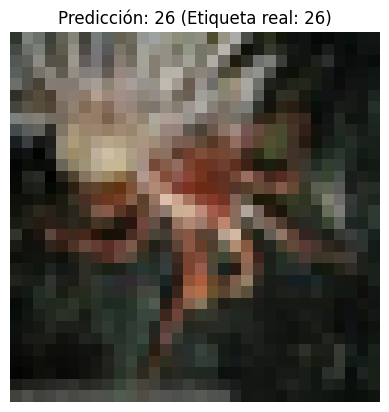

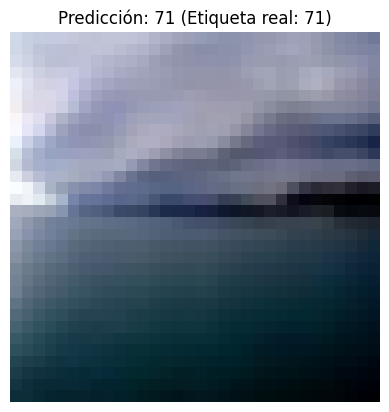

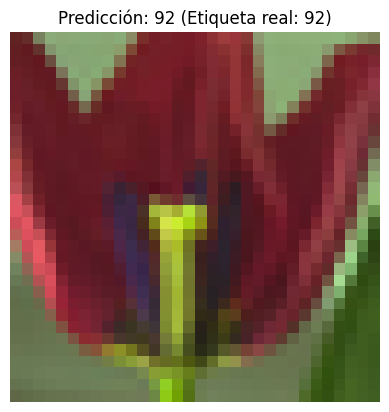

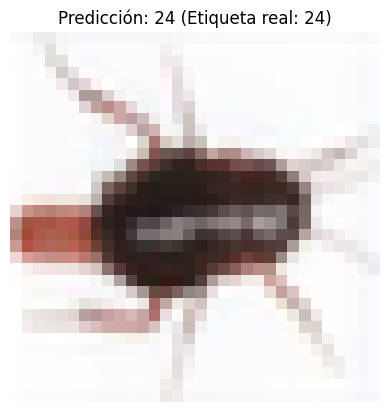

In [34]:
# Función para mostrar imágenes y predicciones
import matplotlib.pyplot as plt

def mostrar_predicciones(indices, dataset, modelo, device):
    modelo.eval()
    for idx in indices:
        img, lbl = dataset[idx]
        img_gpu = img.unsqueeze(0).to(device)
        with torch.no_grad():
            logits = modelo(img_gpu)
            pred = logits.argmax(1).item()
        plt.imshow(img.permute(1, 2, 0).cpu() * 0.5 + 0.5)
        plt.title(f"Predicción: {pred} (Etiqueta real: {lbl})")
        plt.axis("off")
        plt.show()

# Ejemplo de uso:
mostrar_predicciones([100, 80, 2000, 241], test_dataset, modelo, device)

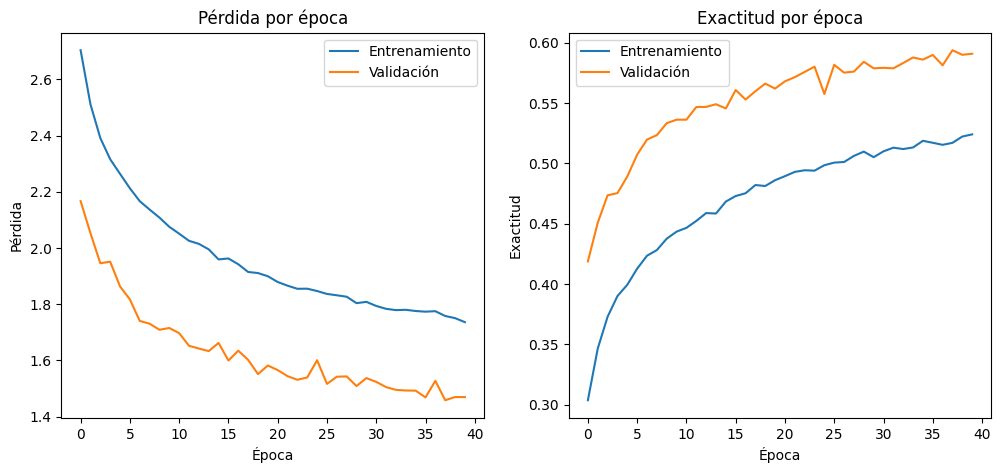

In [35]:
# 10. Graficar la pérdida y exactitud por época y guardar figuras
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.savefig('perdida_por_epoca.png')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento')
plt.plot(val_accuracies, label='Validación')
plt.title('Exactitud por época')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()
plt.savefig('exactitud_por_epoca.png')
plt.show()

In [36]:
# 11. Calcular métricas adicionales de clasificación en el set de test
from sklearn.metrics import classification_report, balanced_accuracy_score

modelo.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = modelo(X)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

report = classification_report(all_labels, all_preds, digits=4, output_dict=False)
bal_acc = balanced_accuracy_score(all_labels, all_preds)

from IPython.display import Markdown, display
display(Markdown(f'**Balanced Accuracy:** {bal_acc:.4f}'))
display(Markdown('**Classification Report:**'))
display(Markdown(f'```{report}```'))

**Balanced Accuracy:** 0.5967

**Classification Report:**

```              precision    recall  f1-score   support

           0     0.7500    0.9000    0.8182       100
           1     0.6096    0.8900    0.7236       100
           2     0.3816    0.5800    0.4603       100
           3     0.4211    0.4000    0.4103       100
           4     0.3173    0.3300    0.3235       100
           5     0.4697    0.6200    0.5345       100
           6     0.7216    0.7000    0.7107       100
           7     0.7037    0.5700    0.6298       100
           8     0.8333    0.7000    0.7609       100
           9     0.8065    0.7500    0.7772       100
          10     0.5410    0.3300    0.4099       100
          11     0.4300    0.4300    0.4300       100
          12     0.7073    0.5800    0.6374       100
          13     0.5763    0.3400    0.4277       100
          14     0.7955    0.3500    0.4861       100
          15     0.4946    0.4600    0.4767       100
          16     0.4867    0.7300    0.5840       100
          17     0.8298    0.7800    0.8041       100
          18     0.4885    0.6400    0.5541       100
          19     0.7391    0.3400    0.4658       100
          20     0.6860    0.8300    0.7511       100
          21     0.6891    0.8200    0.7489       100
          22     0.6170    0.5800    0.5979       100
          23     0.6882    0.6400    0.6632       100
          24     0.7300    0.7300    0.7300       100
          25     0.4756    0.3900    0.4286       100
          26     0.5294    0.6300    0.5753       100
          27     0.3980    0.3900    0.3939       100
          28     0.8021    0.7700    0.7857       100
          29     0.6506    0.5400    0.5902       100
          30     0.4408    0.6700    0.5317       100
          31     0.5229    0.5700    0.5455       100
          32     0.7206    0.4900    0.5833       100
          33     0.3710    0.6900    0.4825       100
          34     0.4305    0.6500    0.5179       100
          35     0.3418    0.2700    0.3017       100
          36     0.6731    0.7000    0.6863       100
          37     0.5338    0.7900    0.6371       100
          38     0.3291    0.5200    0.4031       100
          39     0.8488    0.7300    0.7849       100
          40     0.4609    0.5900    0.5175       100
          41     0.8000    0.8000    0.8000       100
          42     0.6176    0.6300    0.6238       100
          43     0.5254    0.6200    0.5688       100
          44     0.4035    0.2300    0.2930       100
          45     0.4783    0.4400    0.4583       100
          46     0.4767    0.4100    0.4409       100
          47     0.5900    0.5900    0.5900       100
          48     0.6597    0.9500    0.7787       100
          49     0.7959    0.7800    0.7879       100
          50     0.4000    0.2000    0.2667       100
          51     0.6437    0.5600    0.5989       100
          52     0.5496    0.7200    0.6234       100
          53     0.6429    0.9000    0.7500       100
          54     0.6397    0.8700    0.7373       100
          55     0.3704    0.1000    0.1575       100
          56     0.9024    0.7400    0.8132       100
          57     0.7763    0.5900    0.6705       100
          58     0.7238    0.7600    0.7415       100
          59     0.6447    0.4900    0.5568       100
          60     0.8144    0.7900    0.8020       100
          61     0.5200    0.6500    0.5778       100
          62     0.8125    0.5200    0.6341       100
          63     0.6667    0.5200    0.5843       100
          64     0.4455    0.4500    0.4478       100
          65     0.6207    0.1800    0.2791       100
          66     0.7172    0.7100    0.7136       100
          67     0.4884    0.4200    0.4516       100
          68     0.9032    0.8400    0.8705       100
          69     0.7778    0.7700    0.7739       100
          70     0.7241    0.6300    0.6738       100
          71     0.5578    0.8200    0.6640       100
          72     0.5000    0.1500    0.2308       100
          73     0.4444    0.3200    0.3721       100
          74     0.3909    0.4300    0.4095       100
          75     0.9524    0.8000    0.8696       100
          76     0.8627    0.8800    0.8713       100
          77     0.4625    0.7400    0.5692       100
          78     0.5000    0.5300    0.5146       100
          79     0.5352    0.7600    0.6281       100
          80     0.3191    0.3000    0.3093       100
          81     0.4706    0.8000    0.5926       100
          82     0.9140    0.8500    0.8808       100
          83     0.6600    0.3300    0.4400       100
          84     0.6250    0.5000    0.5556       100
          85     0.7476    0.7700    0.7586       100
          86     0.7714    0.5400    0.6353       100
          87     0.7922    0.6100    0.6893       100
          88     0.5423    0.7700    0.6364       100
          89     0.5906    0.7500    0.6608       100
          90     0.7237    0.5500    0.6250       100
          91     0.6757    0.7500    0.7109       100
          92     0.5000    0.6000    0.5455       100
          93     0.4598    0.4000    0.4278       100
          94     0.7890    0.8600    0.8230       100
          95     0.5248    0.5300    0.5274       100
          96     0.5699    0.5300    0.5492       100
          97     0.7093    0.6100    0.6559       100
          98     0.5909    0.2600    0.3611       100
          99     0.5946    0.6600    0.6256       100

    accuracy                         0.5967     10000
   macro avg     0.6095    0.5967    0.5889     10000
weighted avg     0.6095    0.5967    0.5889     10000
```

# Ajuste de hiperparámetros para hardware sin GPU


In [37]:
# Ajustar batch size, número de épocas y optimizador Adam para CPU
BATCH_SIZE = 16  # Recomendado para CPU y 16GB RAM
EPOCHS = 50      # Más épocas para compensar batch pequeño

# Optimización de Adam con weight_decay para regularización
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001, weight_decay=1e-4)

# Actualizar DataLoaders
train_loader = DataLoader(train_dataset_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_split, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)